# Running pw.x in AiiDA


## Basic Quantum Espresso Example

As a first example, lets take a look at how to run a simple calculation using the `pw.x` code from the [Quantum ESPRESSO](https://www.quantum-espresso.org/) package.

Running without AiiDA, we could use the following input file:

In [105]:
!cat direct_run/aiida.in

&CONTROL
  calculation = 'relax'
  etot_conv_thr =   2.0000000000d-04
  forc_conv_thr =   1.0000000000d-03
  max_seconds =   86400
  outdir = './out/'
  prefix = 'aiida'
  pseudo_dir = './pseudo/'
  restart_mode = 'from_scratch'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  degauss =   1.0000000000d-02
  ecutrho =   2.4000000000d+02
  ecutwfc =   3.0000000000d+01
  ibrav = 0
  nat = 2
  nosym = .false.
  ntyp = 1
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
  conv_thr =   8.0000000000d-10
  electron_maxstep = 80
  mixing_beta =   4.0000000000d-01
/
&IONS
/
ATOMIC_SPECIES
Si     28.085 Si.pbe-n-rrkjus_psl.1.0.0.UPF
ATOMIC_POSITIONS angstrom
Si           0.0000000000       0.0000000000       0.0000000000 
Si           1.8940738226       1.0935440313       0.7732524001 
K_POINTS automatic
5 5 5 0 0 0
CELL_PARAMETERS angstrom
      3.7881476452       0.0000000000       0.0000000000
      1.8940738226       3.2806320940       0.0000000000
      1.8940

We could then run the calculation, on the available CPU cores.

In [1]:
import psutil
cpu_count = psutil.cpu_count(logical=False)
cpu_count

4

In [10]:
!mkdir -p direct_run/out
!rm -rf direct_run/out/*
!cd direct_run && mpirun -np {min(cpu_count, 2)} pw.x -in aiida.in > out/aiida.out

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


We now have access to the text based and XML output files, which we can parse to extract the relevant results.

In [106]:
!ls direct_run/out

aiida.out  aiida.save aiida.xml


In [61]:
!tail -n 5 direct_run/out/aiida.out

   This run was terminated on:  21:58:59  20Sep2022            

=------------------------------------------------------------------------------=
   JOB DONE.
=------------------------------------------------------------------------------=


In [122]:
from pathlib import Path
import xmltodict

xml_output = xmltodict.parse(Path("direct_run/out/aiida.xml").read_bytes())
xml_output["qes:espresso"]["output"]["convergence_info"]


{'scf_conv': {'convergence_achieved': 'true',
  'n_scf_steps': '8',
  'scf_error': '2.047382223968647e-10'},
 'opt_conv': {'convergence_achieved': 'true',
  'n_opt_steps': '0',
  'grad_norm': '1.213624545212296e-6'}}

This is a very simple example, that one could run without any automation.
However, as the number of calculations increases, and the complexity of the input files, it becomes increasingly difficult to keep track of the calculations, and to reproduce them:

:::{admonition} Complex Computations

- What if we want to run more than one computation?
- What if we want to chain this computation to others?
- What if things go wrong?
- How do we work with a HPC cluster?

:::


## Implementing in AiiDA


With AiiDA we want to split the input generation into separate *Nodes*, handling the different aspects of the calculation and allow for component re-use:

- `Computer`, which describes how we interface with a compute resource
- `Code`, which contains the information on how to execute the calculation
- `StructureData`, which contains the crystal structure
- `UpfData`, which contains the pseudo-potentials per atomic
- `KpointsData`, which contains the k-point mesh
- `Dict` node, which contains the parameters for the calculation

### The AiiDA Profile

First we create a new AiiDA profile.
This is where we store all these nodes for a project, and the links between them.

In [125]:
import os
os.environ["AIIDA_PATH"] = os.path.abspath("_aiida_config")
from aiida import engine, load_profile, orm, plugins
from aiida.storage.sqlite_temp import SqliteTempBackend
from aiida.tools.visualization import Graph
%load_ext aiida

The aiida extension is already loaded. To reload it, use:
  %reload_ext aiida


In [126]:
profile = load_profile(
    SqliteTempBackend.create_profile(
        "temp_profile",
        options={"runner.poll.interval": 1},
        debug=False,
    ),
)
profile

Profile<uuid='4f1051f9b05b4a5c9210cec868c76d8e' name='temp_profile'>

AiiDA can be controlled in two main ways:

1. Using the Python API, which is the most flexible, but requires some programming knowledge. 
2. Using the `verdi` command line interface (CLI), which is more limited, but easier to use.

Below we check the status of our loaded profile in the CLI:

In [4]:
%verdi status --no-rmq

 ✔ version:     AiiDA v2.0.1
 ✔ config:      /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_config/.aiida
 ✔ profile:     temp_profile
 ✔ storage:     SqliteTemp storage [open], sandbox: /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_config/.aiida/repository/temp_profile
 ⏺ daemon:      The daemon is not running


### Setting up a compute resource

In [127]:
created, computer = orm.Computer.collection.get_or_create(
    label="local_direct",
    description="local computer with direct scheduler",
    hostname="localhost",
    workdir=os.path.abspath("_aiida_workdir"),
    transport_type="core.local",
    scheduler_type="core.direct",
)
if created:
    computer.store()
    computer.set_minimum_job_poll_interval(0.0)
    computer.set_default_mpiprocs_per_machine(2)
    computer.configure()
computer

<Computer: local_direct (localhost), pk: 1>

In [25]:
import shutil
try:
    code = orm.load_code("pw.x@local_direct")
except:
    code = orm.Code(
        input_plugin_name="quantumespresso.pw",
        remote_computer_exec=[computer, shutil.which("pw.x")],
    )
    code.label = "pw.x"
    code.store()
code

<Code: Remote code 'pw.x' on local_direct, pk: 114, uuid: 39b7288d-0967-4892-b0f5-1e525c510688>

In [42]:
builder = code.get_builder()

import qe_tools

pw_input = qe_tools.parsers.PwInputFile(open("direct_run/aiida.in").read())

builder.structure = orm.StructureData(cell=pw_input.structure["cell"])
for p, s in zip(pw_input.structure["positions"], pw_input.structure["atom_names"]):
    builder.structure.append_atom(position=p, symbols=s)

parameters = pw_input.namelists
for disallowed in ["pseudo_dir", "outdir", "prefix"]:
    parameters["CONTROL"].pop(disallowed, None)
for disallowed in ["nat", "ntyp"]:
    parameters["SYSTEM"].pop(disallowed, None)
builder.parameters = orm.Dict(dict=parameters)

builder.kpoints = orm.KpointsData()
builder.kpoints.set_cell_from_structure(builder.structure)
builder.kpoints.set_kpoints_mesh(
    pw_input.k_points["points"],
    offset=pw_input.k_points["offset"],
)

builder.pseudos = {
    "Si": orm.UpfData.get_or_create(
        os.path.abspath("direct_run/pseudo/Si.pbe-n-rrkjus_psl.1.0.0.UPF")
    )[0]
}

builder

Process class: PwCalculation
Inputs:
code: ''
kpoints: 'Kpoints mesh: 5x5x5 (+0.0,0.0,0.0)'
metadata:
  options:
    stash: {}
parameters:
  CONTROL:
    calculation: relax
    etot_conv_thr: 0.0002
    forc_conv_thr: 0.001
    max_seconds: 41040.0
    restart_mode: from_scratch
    tprnfor: true
    tstress: true
    verbosity: high
  ELECTRONS:
    conv_thr: 8.0e-10
    electron_maxstep: 80
    mixing_beta: 0.4
  SYSTEM:
    degauss: 0.01
    ecutrho: 240.0
    ecutwfc: 30.0
    ibrav: 0
    nosym: false
    occupations: smearing
    smearing: cold
pseudos:
  Si: ''
structure: Si


In [ ]:
output = engine.run_get_node(builder)
output

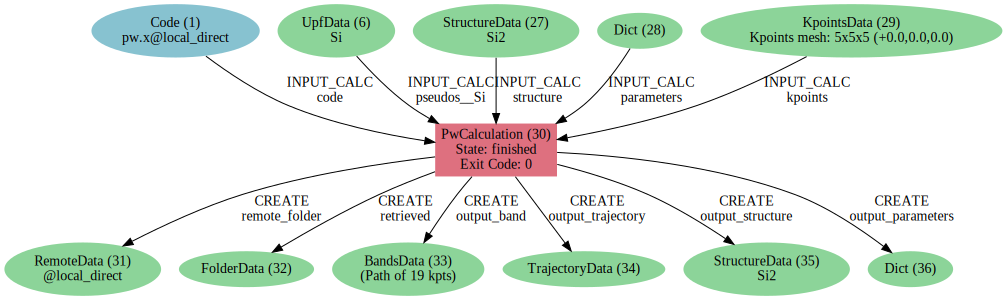

In [43]:
graph = Graph()
graph.add_incoming(output.node, annotate_links="both")
graph.add_outgoing(output.node, annotate_links="both")
graph.graphviz

In [65]:
%verdi storage info

entities:
  Users:
    count: 1
  Computers:
    count: 1
  Nodes:
    count: 36
  Groups:
    count: 0
  Comments:
    count: 0
  Logs:
    count: 6
  Links:
    count: 40

